<a href="https://colab.research.google.com/github/joaopmt/CS-classes-projects/blob/master/project2/logistic-regression_neural-net_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment \#2**: Machine Learning MC886
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2020s2



In [ ]:
# TODO: RA & Name 
print('176117: ' + 'João Pedro Martins')
print('185531: ' + 'Pedro Alan Tapia Ramos')

176117: João Pedro Martins
185531: Pedro Alan Tapia Ramos


### Objective 

Explore **classification techniques** (logistic regression & neural networks) and come up with the best possible model to the problem, avoiding overfitting. In particular, build an object recognition system to accurately classify images using the Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist).

## Dataset

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


Each training and test example is assigned to one of the following labels:

**Label 	Description**
- 0 	t-shirt/top
- 1 	trouser
- 2 	pullover
- 3 	dress
- 4 	coat
- 5 	sandal
- 6 	shirt
- 7 	sneaker
- 8 	bag
- 9 	ankle boot

**Dataset Information:**

- You should respect the following traininig/test split: 60,000 training examples, and 10,000 test examples. Avoid overfitting.
- The data is available at: https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip: 'train' folder (fashion-mnist_train.csv.zip) + 'test' folder (fashion-mnist_test.csv.zip)	
- Each row is a separate image. Column 1 is the class label. Remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255). Dataset was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv.


## Deadline

Monday, November 16th 7pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you did, your grade will be penalized as follows:
- November 17th 7pm : grade * 0.75
- November 18th 7pm : grade * 0.5
- November 19th 7pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix


## Activities

1. (2 points) Perform Multinomial Logistic Regression (_i.e._, softmax regression). It is a generalization of Logistic Regression to the case where we want to handle multiple classes. **You should implement your solution**.


In [ ]:
class MultinomialLogisticRegressor:

  def __init__(self, learning_rate=1e-4, n_epochs=30, batch_size=1024, log_epochs=False):
    self.learning_rate = learning_rate
    self.n_epochs = n_epochs
    self.k = 0 # Number of classes.
    self.batch_size = batch_size
    self.log_epochs = log_epochs
    self.cost = None
    self.params = None
    self.theta0 = None
  

  def fit(self, X_train, y_train, X_validation, y_validation):
    '''
    `X_train`: numpy array of features to be used in training.
    `y_train`: numpy array of targets for the given features to be used in
    training.
    `X_validation`: numpy array of features to be used for logging the cost at
    each epoch for validation.
    `y_validation`: numpy array of targets for the given features to be used for
    logging the cost at each epoch for validation.
    '''
    _, n_pixels = X_train.shape
    self.k = np.unique(y_train).shape[0]
    print('Total of classes:', self.k)
    self.params = np.random.rand(self.k, n_pixels)
    self.theta0 = np.random.rand(self.k, 1)
    self.cost = np.array([])

    for epoch in range(self.n_epochs):
      # Shuffle data.
      permutation = np.random.permutation(X_train.shape[0])
      X = X_train[permutation]
      y = y_train[permutation]

      # Mini batch gradient descent.
      for i in range(0, X.shape[0], self.batch_size): 
        mini_X = X[i:i+self.batch_size]
        mini_y = y[i:i+self.batch_size]

        probabilities, _ = self.predict(mini_X)
        probabilities[np.arange(mini_X.shape[0]), mini_y] -= 1

        # Get gradients.
        d_params = probabilities.T.dot(mini_X)
        d_theta0 = np.sum(probabilities, axis = 0).reshape(-1,1)

        # Update parameters.
        self.params -= (self.learning_rate * d_params)
        self.theta0 -= (self.learning_rate * d_theta0)

      if self.log_epochs:
        # Calculate cost.
        probabilities, _ = self.predict(X_validation)
        CECost = self.cross_entropy_cost(probabilities, y_validation)
        print('Epoch:', epoch, 'Cost:', CECost)
        self.cost = np.append(self.cost, CECost)


  def predict(self, X):
    '''
    Generates a pair of output probabilities and predictions for the given batch
    of features.
    '''
    logit_scores = self.linear_predict(X)
    probabilities = self.softmax_normalizer(logit_scores)
    predictions = np.array([np.argmax(i) for i in probabilities]) # returns the outcome with max probability
    return probabilities, predictions


  def linear_predict(self, X):
    '''
    Calculates logit scores for given feature samples.
    '''
    logit_scores = np.array([np.empty([self.k]) for i in range(X.shape[0])]).astype(np.float128)
    for i in range(X.shape[0]): # iterating through each image
        logit_scores[i] = (self.params.dot(X[i].reshape(-1,1)) + self.theta0).reshape(-1)

    return logit_scores


  def softmax_normalizer(self, logit_matrix):
    '''
    Transforms the given logit scores to probabilities that sum up to 1.
    `logit_matrix`: matrix containing logit scores for multiple input samples.
    Returns `probabilities`: matrix containing probabilities for given logit
    scores.
    '''
    probabilities = np.array([np.empty([self.k]) for i in range(logit_matrix.shape[0])]) # creating empty(garbage value) array for each feature set

    for i in range(logit_matrix.shape[0]):
        exp = np.exp(logit_matrix[i]) # Exponentiates each element of the logit array.
        sumOfArr = np.sum(exp) # Adds up all the values in the exponentiated array.
        probabilities[i] = exp / sumOfArr # Logit scores to probability values.

    return probabilities


  def cross_entropy_cost(self, probabilities, target):
    '''
    Calculates the cross entropy cost for the given pair of probalities and
    target.
    `target`: 2D matrix of shape (n_samples, 1) containing the correct target
    class number for each sample.
    `probabilities`: 2D matrix of shape (n_samples, 10) containing the array of
    probabilities for each sample.
    Returns `CECost`: scalar value of the cost.
    '''
    n_samples = probabilities.shape[0]
    CECost = 0
    for sample, i in zip(probabilities, target):
      CECost += -np.log(sample[i])
    CECost /= n_samples

    return CECost


  def standardScaler(self, X):
    '''
    Scale the feature set so it has mean 0 and standard deviation 1.
    '''
    total_cols = X.shape[1]
    for i in range(total_cols):
      X_col = X[:, i]
      mean = X_col.mean()
      std = X_col.std()
      X[:, i] = (X[:, i] - mean) / std


Total of classes: 10
Epoch: 0 Cost: 1.6828628262861869
Epoch: 1 Cost: 1.339689017685784
Epoch: 2 Cost: 1.1823751978825743
Epoch: 3 Cost: 1.0849588810954758
Epoch: 4 Cost: 1.016824541983306
Epoch: 5 Cost: 0.9659426640418842
Epoch: 6 Cost: 0.9229369158129066
Epoch: 7 Cost: 0.8896760452238419
Epoch: 8 Cost: 0.8638250026456477
Epoch: 9 Cost: 0.8407601244750639
Epoch: 10 Cost: 0.8203978578780298
Epoch: 11 Cost: 0.8011950812902598
Epoch: 12 Cost: 0.7857310210287748
Epoch: 13 Cost: 0.7716039761526624
Epoch: 14 Cost: 0.7578917240659327
Epoch: 15 Cost: 0.7479394745615884
Epoch: 16 Cost: 0.7398956833548915
Epoch: 17 Cost: 0.7260145060992345
Epoch: 18 Cost: 0.7136300458897301
Epoch: 19 Cost: 0.7074267696345795
Epoch: 20 Cost: 0.6989211986127217
Epoch: 21 Cost: 0.692536024304709
Epoch: 22 Cost: 0.683804767430969
Epoch: 23 Cost: 0.6767749118430699
Epoch: 24 Cost: 0.6706246579974345
Epoch: 25 Cost: 0.6651723278754933
Epoch: 26 Cost: 0.6586219825841108
Epoch: 27 Cost: 0.6538094541803866
Epoch: 28 Cos

Text(0, 0.5, 'cost')

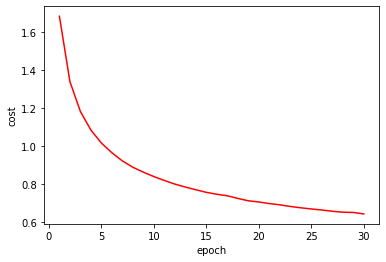

In [ ]:
# Load training set.
df = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_train.csv") # Assuming you have this path

y = df['label'].to_numpy()
del df['label']
X = df.to_numpy().astype(np.float128) # float64 and below will overflow.
del df

regressor = MultinomialLogisticRegressor(log_epochs=True)
regressor.standardScaler(X)

X_train = X[:50000]
X_validation = X[50000:]
y_train = y[:50000]
y_validation = y[50000:]

regressor.fit(X_train, y_train, X_validation, y_validation)

plt.plot(list(range(1, len(regressor.cost)+1)), regressor.cost, color='r')
plt.xlabel('epoch')
plt.ylabel('cost')

In [ ]:
# Load test set.
df_test = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_test.csv") # Assuming you have this path

y_test = df_test['label'].to_numpy()
del df_test['label']
X_test = df_test.to_numpy().astype(np.float128) # float64 and below will overflow.
del df_test

regressor.standardScaler(X_test)

y_probabilities, y_predicted = regressor.predict(X_test)

print(regressor.cross_entropy_cost(y_probabilities, y_test))

0.6310898961151216



> What are the conclusions? (1-2 paragraphs)

Our model is a multinomial logistic regressor that uses the softmax function to classify the set of features over 10 classes. The feature set is scaled so it has mean 0 and standard deviation 1. The cost function used is the cross entropy cost function. The original training set is subdivided in a new training set with 50K samples and a validation set with 10K samples.

Each epoch is processed fairly fast since computations are mostly simple, done with numpy multiplication of 2D matrices. The cost x epoch graph shows an elbow at around the 7th epoch, which means this is the point the learning slows down. During training, the model hit a cost of 0.644 in 30 epochs, being evaluated with the validation set. With the testing set, the model hit a cost of 0.631, lower than what was hit in training, thus showing no signs of overfitting.




2. (6 points) Move on to Neural Networks, using _one_ or _two hidden layers_. **You should implement your solution** (weight & bias initialization, forward propagation, backward propagation, activation function, ...).


In [ ]:
import numpy as np

class NeuralNetwork:

  def __init__(self, layer_sizes, activation_f, activation_f_derivative, 
               learning_rate=1e-3, n_epochs=30, batch_size=1024, log_epochs=False):
    self.learning_rate = learning_rate
    self.n_epochs = n_epochs
    self.batch_size = batch_size
    self.log_epochs = log_epochs
    self.layer_sizes = layer_sizes 
    self.activation_f = activation_f # Activation function
    self.activation_f_derivative = activation_f_derivative
    self.num_layers = len(layer_sizes)
    self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
    self.weights = [np.random.randn(y, x) * np.sqrt(2.0 / x) \
                    for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
    self.cost = np.array([])
  

  def fit(self, X_train, y_train, X_validation, y_validation):
    '''
    `X_train`: numpy array of features to be used in training.
    `y_train`: numpy array of targets for the given features to be used in
    training.
    `X_validation`: numpy array of features to be used for logging the cost at
    each epoch for validation.
    `y_validation`: numpy array of targets for the given features to be used for
    logging the cost at each epoch for validation.
    '''
    # Vectorize y arrays.
    y_train_vectorized = vectorize_target(y_train)
    y_validation_vectorized = vectorize_target(y_validation)

    for epoch in range(self.n_epochs):
      # Shuffle data.
      permutation = np.random.permutation(X_train.shape[0])
      X_train = X_train[permutation]
      y_train_vectorized = y_train_vectorized[permutation]

      # Mini batch gradient descent.
      for i in range(0, X_train.shape[0], self.batch_size):
        mini_X = X_train[i:i+self.batch_size]
        mini_y = y_train_vectorized[i:i+self.batch_size]

        self.process_mini_batch_simultaneous(mini_X, mini_y)

      if self.log_epochs:
        # Calculate cost.
        CECost = self.calculate_cost(X_validation, y_validation_vectorized)
        print('Epoch:', epoch, 'Cost:', CECost)
        self.cost = np.append(self.cost, CECost)
    

  def process_mini_batch_simultaneous(self, mini_X, mini_y):
    '''
    Process the given mini-batch with a matrix-based approach.
    '''
    gradient_w, gradient_b = self.backpropagation_simultaneous(mini_X.T, mini_y.T)

    batch_size = mini_X.shape[0]

    self.weights = [
        w - (self.learning_rate / batch_size) * gradw
        for w, gradw in zip(self.weights, gradient_w)
    ]
    self.biases = [
        b - (self.learning_rate / batch_size) * gradb
        for b, gradb in zip(self.biases, gradient_b)
    ]

    return gradient_w, gradient_b

  
  def backpropagation_simultaneous(self, x, y):
    '''
    Computes the gradients for all training examples in the given mini-batch
    simultaneously. Here, `x` is an (input x batch_size) matrix and `y` is an
    (output x batch_size) matrix. This matrix-based approach has over 2x speedup
    when compared to iterating through each sample in the batch individually. 
    '''
    gradient_b = [0 for i in self.biases]
    gradient_w = [0 for i in self.weights]

    # Feedforward.
    activation = x
    activations = [x]
    zs = []
    for b, w in zip(self.biases, self.weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = self.activation_f(z)
        activations.append(activation)

    # Backward pass.
    activations[-1] = self.softmax_normalizer1D(activations[-1])
    delta = self.cross_entropy_cost_derivate(activations[-1], y)
    gradient_b[-1] = delta.sum(1).reshape([len(delta), 1]) # Reshape to (n x 1) matrix.
    gradient_w[-1] = np.dot(delta, activations[-2].T)

    for l in range(2, self.num_layers):
        z = zs[-l]
        delta = np.dot(self.weights[-l + 1].T, delta) * self.activation_f_derivative(z)
        gradient_b[-l] = delta.sum(1).reshape([len(delta), 1]) # Reshape to (n x 1) matrix.
        gradient_w[-l] = np.dot(delta, activations[-l - 1].T)

    return (gradient_w, gradient_b)


  def calculate_cost(self, X, y):
    '''
    Calculate and returns the cost of the given pair of input output matrices.
    Note that this is the cost (not loss), so it is based on all the samples of
    the set.
    '''
    # Gets probabilities matrix for all samples.
    probabilities = \
        self.softmax_normalizer(
            np.array(
                [self.feedforward(x.reshape(x.shape[0], 1)) for x in X]))
        
    n_samples = probabilities.shape[0]
    CECost = self.cross_entropy_cost(probabilities, y) / n_samples

    return CECost


  def feedforward(self, a):
    '''
    Runs the given input array `a` through the network and returns the output
    activation at the last layer.
    '''
    for b, w in zip(self.biases, self.weights):
        a = self.activation_f(np.dot(w, a) + b)

    return a.reshape(a.shape[0])


  def softmax_normalizer(self, activations):
    '''
    Transforms the given activations to probabilities that sum up to 1.
    `activations`: matrix containing activations for multiple input samples.
    Returns `probabilities`: matrix containing probabilities for given
    activations.
    '''
    probabilities = \
        np.array(
            [np.empty([self.layer_sizes[-1]])
             for i in range(activations.shape[0])])

    for i in range(activations.shape[0]):
        exp = np.exp(activations[i]) # Exponentiates each element of the activation array.
        sumOfArr = np.sum(exp) # Adds up all the values in the exponentiated array.
        probabilities[i] = exp/sumOfArr # Activation to probability values.
        
    return probabilities


  def softmax_normalizer1D(self, activation):
    '''
    Transforms the given activation to probabilities that sum up to 1.
    `activation`: array containing the activation for a layer.
    Returns `probabilities`: array containing probabilities for the given
    activation.
    '''
    probabilities = np.empty(activation.shape).T
        
    for i in range(probabilities.shape[0]):
        exp = np.exp(activation.T[i]) # Exponentiates each element of the activation array.
        sumOfArr = np.sum(exp) # Adds up all the values in the exponentiated array
        probabilities[i] = exp/sumOfArr # Activation to probability values.
        
    return probabilities.T


  def cross_entropy_cost(self, probabilities, target):
    return np.sum(
        np.nan_to_num(
            -target * np.log(probabilities) - (1 - target) \
                * np.log(1 - probabilities)))


  def cross_entropy_cost_derivate(self, probabilities, target):
    return probabilities - target


  def standardScaler(self, X):
    '''
    Scale the feature set so it has mean 0 and standard deviation 1.
    '''
    total_cols = X.shape[1]
    for i in range(total_cols):
      X_col = X[:, i]
      mean = X_col.mean()
      std = X_col.std()
      X[:, i] = (X[:, i] - mean) / std


def vectorize_target(target_array):
  '''
  Returns vectorized version of the given target array so that
  `vectorized_target_array[i, k] = 1 if target_array[i] = k else 0`.
  '''
  vectorized_target_array = \
      np.zeros([target_array.shape[0], self.layer_sizes[-1]])

    for i, target_class in enumerate(target_array):
      vectorized_target_array[i, target_class] = 1

  return vectorized_target_array


def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))


def sigmoid_derivative(z):
  sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))
  return sigmoid(z) * (1 - sigmoid(z))


def leaky_relu(z):
  return z * (z > 0) + (0.01 * z) * (z <= 0)


def leaky_relu_derivative(z):
  return 1 * (z > 0) + 0.01 * (z <= 0)

Epoch: 0 Cost: 2.587999016955467
Epoch: 1 Cost: 2.0306516955931513
Epoch: 2 Cost: 1.7681913102537024
Epoch: 3 Cost: 1.6161687468810335
Epoch: 4 Cost: 1.5165708778564762
Epoch: 5 Cost: 1.4450071490603078
Epoch: 6 Cost: 1.3904671566789355
Epoch: 7 Cost: 1.3472365160216668
Epoch: 8 Cost: 1.3115871591511556
Epoch: 9 Cost: 1.2814429403368457
Epoch: 10 Cost: 1.2546874414754896
Epoch: 11 Cost: 1.2316677595600733
Epoch: 12 Cost: 1.2111868998745525
Epoch: 13 Cost: 1.1928005384241
Epoch: 14 Cost: 1.1761748442676072
Epoch: 15 Cost: 1.161218489746445
Epoch: 16 Cost: 1.14699918294709
Epoch: 17 Cost: 1.1337474695475924
Epoch: 18 Cost: 1.122174569543747
Epoch: 19 Cost: 1.1113049521319238
Epoch: 20 Cost: 1.1006066092984108
Epoch: 21 Cost: 1.0908168232021467
Epoch: 22 Cost: 1.0817244254436849
Epoch: 23 Cost: 1.0729088331823904
Epoch: 24 Cost: 1.0647789797122473
Epoch: 25 Cost: 1.0569354926754584
Epoch: 26 Cost: 1.0493521588953734
Epoch: 27 Cost: 1.0424763095611178
Epoch: 28 Cost: 1.0358401734873246
Epo

Text(0, 0.5, 'loss')

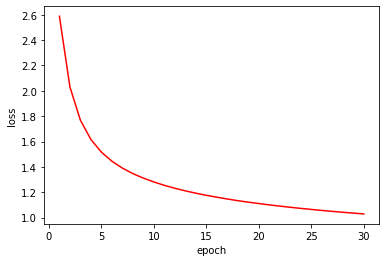

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt

# Load training set.
df = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_train.csv") # Assuming you have this path
y = df['label'].to_numpy()
del df['label']
X = df.to_numpy().astype(np.float128) # float64 and below will overflow.
del df

neural_network = NeuralNetwork([784, 900, 10], leaky_relu, 
                               leaky_relu_derivative, log_epochs=True)

neural_network.standardScaler(X)

X_train = X[:50000]
X_validation = X[50000:]
y_train = y[:50000]
y_validation = y[50000:]

neural_network.fit(X_train, y_train, X_validation, y_validation)

plt.plot(list(range(1, len(neural_network.cost)+1)), neural_network.cost, color='r')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
# Load test set.
df_test = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_test.csv") # Assuming you have this path

y_test = df_test['label'].to_numpy()
del df_test['label']
X_test = df_test.to_numpy().astype(np.float128) # float64 and below will overflow.
del df_test

y_test_normalized = np.zeros([y_test.shape[0], 10])
for i, target_class in enumerate(y_test):
  y_test_normalized[i, target_class] = 1

neural_network.standardScaler(X_test)
print('Cross Entropy cost', neural_network.calculate_cost(X_test, y_test_normalized))

Cross Entropy cost 1.0248343382463279


> What are the conclusions? Regarding the Multinomial Logistic Regression model, does the performance improve? (2-4 paragraphs)

The structure of our neural network consisting of three layers. The first (input) layer has 784 neurons representing each pixel of the image,
the second (hidden) layer has 900 neurons and the final (output) layer has 10, representing each class of clothes. Also, each
neuron has a bias associated with it. The output layer has this configuration so that, given an image in the input layer, 
each neuron of the output layer represents how much the NN thinks the image represents the class related to that neuron. 
To translate these neurons values to actual probabilities of an image being of a certain class, 
we use the Softmax Normalizer on each output neuron to get a prediction.

This network has some changes when compared to a "raw" neural network. First, its weights and biases start with the He initialization.
Also, we are using the Leaky ReLU activation function instead of the Sigmoid, although this is a parameter in the network initialization and can be changed. However, a major change is how we process the mini-batches and do the backpropagation.
To speed up the training process, we do the backpropagation on the entire mini-batch, using a matrix-based approach.
Finally, we are using the Cross Entropy Cost function in this network, as opposed to the Mean Squared Error. The CECost is better
suited for a classification problem and, with it, we can better compare the results between the NN and the Multinomial Logistic
Regressor (MLR).

As with the MLR, we separate our training data using the same 10K samples each epoch to calculate the cost and visualize the NN
improvement over time. We also run the training for 30 epochs. However, now the vectorization of the target values has to be done
externally (in the MLR they were embedded inside the code). Either inside the NN's fit function or when calculating the cost of the test data, we now vectorize each target value 'k' to an array where the position 'k' is 1, representing that the related image has
probability 1 of being the class 'k'. This is done to better compare results between the NN's output layer and the actual answer.

Finally, when comparing with the MLR, our NN does relatively worse. Starting from a higher place of cost 2.58, the descent is quite
large between epochs 0 through 5, with changes in a 10^-1 magnitude. After that (elbow), it starts to slow down, stopping at 1.029
at epoch 29, fairly worse than the MLR final 0.65 cost. Also, the NN's training is approximately 10x slower than MLR's, taking much more time to process each batch and epoch. A positive side of this NN is that it does not shows signs of overfitting, with a 1.024 cost on the test data.


3. (1 point) Apply two update rules used to optimize Neural Networks (for example, Momentum, Adagrad, Adam, RMSProp, Adadelta). For reference, see http://ruder.io/optimizing-gradient-descent.

In [ ]:
class NeuralNetworkMomentumOpt(NeuralNetwork):

  def __init__(self, layer_sizes, activation_f, activation_f_derivative, 
               learning_rate=1e-3, gamma=0.9, n_epochs=30, batch_size=1024,
               log_epochs=False):
    self.gamma = gamma # Momentum factor.
    super().__init__(layer_sizes, activation_f, activation_f_derivative, 
        learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, log_epochs=log_epochs)


  def fit(self, X_train, y_train, X_validation, y_validation):
    '''
    `X_train`: numpy array of features to be used in training.
    `y_train`: numpy array of targets for the given features to be used in
    training.
    `X_validation`: numpy array of features to be used for logging the cost at
    each epoch for validation.
    `y_validation`: numpy array of targets for the given features to be used for
    logging the cost at each epoch for validation.
    '''
    # Vectorize y arrays.
    y_train_vectorized = vectorize_target(y_train)
    y_validation_vectorized = vectorize_target(y_validation)

    for epoch in range(self.n_epochs):
      # Shuffle data.
      permutation = np.random.permutation(X_train.shape[0])
      X_train = X_train[permutation]
      y_train_normalized = y_train_normalized[permutation]

      # Initialize gradients for the Momentum algorithm. 
      gradient_w = [np.zeros(w.shape) for w in self.weights]
      gradient_b = [np.zeros(b.shape) for b in self.biases]

      # Mini batch gradient descent
      for i in range(0, X_train.shape[0], self.batch_size):
        mini_X = X_train[i:i+self.batch_size]
        mini_y = y_train_normalized[i:i+self.batch_size]

        gradient_w, gradient_b = \
            self.process_mini_batch(mini_X, mini_y, gradient_w, gradient_b)

      if self.log_epochs:
        # Calculate cost.
        CECost = self.calculate_cost(X_validation, y_validation_normalized)
        print('Epoch:', epoch, 'Cost:', CECost)
        self.cost = np.append(self.cost, CECost)


  def process_mini_batch(self, mini_X, mini_y, gradient_w_prev, gradient_b_prev):
    '''
    Process the given mini-batch with a matrix-based approach and returns the
    gradients of the mini-batch to be used in the next mini-batch Momentum.
    '''

    gradient_w, gradient_b = self.backpropagation_simultaneous(mini_X.T, mini_y.T)

    batch_size = mini_X.shape[0]

    gradient_w = [
        (self.learning_rate / batch_size) * gw + self.gamma * prevgw
        for gw, prevgw in zip(gradient_w, gradient_w_prev)
    ]
    gradient_b = [
        (self.learning_rate / batch_size) * gb + self.gamma * prevgb
        for gb, prevgb in zip(gradient_b, gradient_b_prev)
    ]

    self.weights = [w - gradw for w, gradw in zip(self.weights, gradient_w)]
    self.biases = [b - gradb for b, gradb in zip(self.biases, gradient_b)]

    return gradient_w, gradient_b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt

# Load training set.
df = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_train.csv") # Assuming you have this path
y = df['label'].to_numpy()
del df['label']
X = df.to_numpy().astype(np.float128) # float64 and below will overflow.
del df

neural_network = NeuralNetworkMomentumOpt([784, 900, 10], leaky_relu, 
                               leaky_relu_derivative, log_epochs=True)

neural_network.standardScaler(X)

X_train = X[:50000]
X_validation = X[50000:]
y_train = y[:50000]
y_validation = y[50000:]

neural_network.fit(X_train, y_train, X_validation, y_validation)

Epoch: 0 Cost: 1.2916293867665254
Epoch: 1 Cost: 1.1423004637049112
Epoch: 2 Cost: 1.0658410301501098
Epoch: 3 Cost: 1.013978109128626
Epoch: 4 Cost: 0.9744653657622483
Epoch: 5 Cost: 0.9468802921619089
Epoch: 6 Cost: 0.9223426316365249
Epoch: 7 Cost: 0.9012728052533097
Epoch: 8 Cost: 0.8834133465814346
Epoch: 9 Cost: 0.8702698075353344
Epoch: 10 Cost: 0.8568242141073666
Epoch: 11 Cost: 0.8451132243815007
Epoch: 12 Cost: 0.8363683274879741
Epoch: 13 Cost: 0.8258402559753455
Epoch: 14 Cost: 0.8203905916430861
Epoch: 15 Cost: 0.81041449254629
Epoch: 16 Cost: 0.8037535849450537
Epoch: 17 Cost: 0.7969921350146428
Epoch: 18 Cost: 0.7914468980935071
Epoch: 19 Cost: 0.7867213657547766
Epoch: 20 Cost: 0.7807060229583486
Epoch: 21 Cost: 0.7766027037322524
Epoch: 22 Cost: 0.7710607086543139
Epoch: 23 Cost: 0.7676357000199951
Epoch: 24 Cost: 0.7642628337835524
Epoch: 25 Cost: 0.7583294977712816
Epoch: 26 Cost: 0.7550878564716063
Epoch: 27 Cost: 0.7511792216004584
Epoch: 28 Cost: 0.747928948938641

Text(0, 0.5, 'loss')

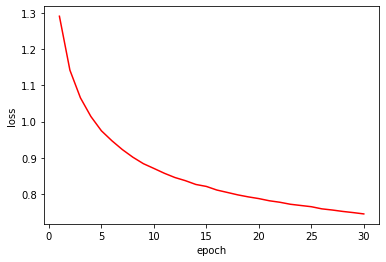

In [ ]:
plt.plot(list(range(1, len(neural_network.cost)+1)), neural_network.cost, color='r')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
# Load test set.
df_test = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_test.csv") # Assuming you have this path

y_test = df_test['label'].to_numpy()
del df_test['label']
X_test = df_test.to_numpy().astype(np.float128) # float64 and below will overflow.
del df_test

y_test_normalized = np.zeros([y_test.shape[0], 10])
for i, target_class in enumerate(y_test):
  y_test_normalized[i, target_class] = 1

neural_network.standardScaler(X_test)
print('Cross Entropy cost', neural_network.calculate_cost(X_test, y_test_normalized))

Cross Entropy cost 0.7308694340837709


In [ ]:
class NeuralNetworkNAGOpt(NeuralNetworkMomentumOpt):

  def process_mini_batch(self, mini_X, mini_y, gradient_w_prev, gradient_b_prev):
    '''
    Process the given mini-batch with a matrix-based approach and returns the
    gradients of the mini-batch to be used in the next mini-batch NAG.
    '''

    # Save current weights and biases so we can load them back later.
    weights = np.copy(self.weights)
    biases = np.copy(self.biases)

    # Change weights and biases for the NAG algotithm
    self.weights = [
        w - self.gamma * gw for w, gw in zip(self.weights,gradient_w_prev)
    ]
    self.biases = [
        b - self.gamma * gb for b, gb in zip(self.biases, gradient_b_prev)
    ]

    # Executes backpropagation using changed weights and biases.
    gradient_w, gradient_b = \
        self.backpropagation_simultaneous(mini_X.T, mini_y.T)

    batch_size = mini_X.shape[0]

    gradient_w = [
        (self.learning_rate / batch_size) * gw + self.gamma * prevgw
        for gw, prevgw in zip(gradient_w, gradient_w_prev)
    ]
    gradient_b = [
        (self.learning_rate / batch_size)*  gb + self.gamma * prevgb
        for gb, prevgb in zip(gradient_b, gradient_b_prev)
    ]

    # Load back the weights and biases.
    self.weights = weights
    self.biases = biases
    
    self.weights = [w - gradw for w, gradw in zip(self.weights, gradient_w)]
    self.biases = [b - gradb for b, gradb in zip(self.biases, gradient_b)]

    return gradient_w, gradient_b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt

# Load training set.
df = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_train.csv") # Assuming you have this path
y = df['label'].to_numpy()
del df['label']
X = df.to_numpy().astype(np.float128) # float64 and below will overflow.
del df

neural_network = NeuralNetworkNAGOpt([784, 900, 10], leaky_relu, 
                               leaky_relu_derivative, log_epochs=True)

neural_network.standardScaler(X)

X_train = X[:50000]
X_validation = X[50000:]
y_train = y[:50000]
y_validation = y[50000:]

neural_network.fit(X_train, y_train, X_validation, y_validation)

Epoch: 0 Cost: 1.2925429061735443
Epoch: 1 Cost: 1.1465984895394405
Epoch: 2 Cost: 1.068895761188559
Epoch: 3 Cost: 1.015897472380631
Epoch: 4 Cost: 0.9767946029509263
Epoch: 5 Cost: 0.9464311232556156
Epoch: 6 Cost: 0.9234022123401666
Epoch: 7 Cost: 0.9026361833890123
Epoch: 8 Cost: 0.8864175237254931
Epoch: 9 Cost: 0.8726474015674234
Epoch: 10 Cost: 0.858109487769395
Epoch: 11 Cost: 0.8480952218856661
Epoch: 12 Cost: 0.8377267151010946
Epoch: 13 Cost: 0.8289853594886872
Epoch: 14 Cost: 0.8210041084247809
Epoch: 15 Cost: 0.813391681124829
Epoch: 16 Cost: 0.8062495214625688
Epoch: 17 Cost: 0.8007753925331784
Epoch: 18 Cost: 0.794682490272821
Epoch: 19 Cost: 0.7886226626644175
Epoch: 20 Cost: 0.7834368747556363
Epoch: 21 Cost: 0.7782572433135083
Epoch: 22 Cost: 0.775065000364802
Epoch: 23 Cost: 0.7705281523300026
Epoch: 24 Cost: 0.7658549957714508
Epoch: 25 Cost: 0.7635005717858655
Epoch: 26 Cost: 0.7590447040636481
Epoch: 27 Cost: 0.7549719367318961
Epoch: 28 Cost: 0.7518501307908604
E

Text(0, 0.5, 'loss')

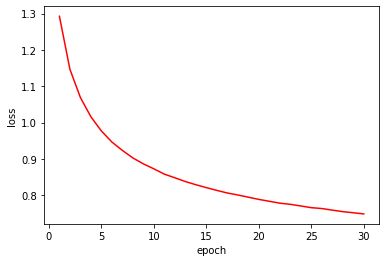

In [ ]:
plt.plot(list(range(1, len(neural_network.cost)+1)), neural_network.cost, color='r')
plt.xlabel('epoch')
plt.ylabel('loss')

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)


In this question, we chose to implement the Momentum (MM) and the Nesterov accelerated gradient (NAG) as the gradient descent optimizers. The Momentum algorithm calculates its current gradient adding up a fraction of the previous one. This fraction is defined by the "gamma" value. This accumulation is supposed to have an effect of an acceleration of the gradient descent. We achieved better results than our initial Neural Network, even if taking into account that this version started at a lower cost value. Between epochs 0 and 1 we had a cost descent of magnitude 10^-1. In the consequent epochs, the descent was fairly "smooth", making this network take more time to reach the "elbow", but still maintaining a stable descent.
The NAG algorithm also did better than our initial Neural Network, with very similar results to Momentum. The NAG algorithm tries to be clever than Momentum by looking ahead at the next position of the parameters when calculating the gradients. This prescience makes it follow, in theory, a better path than Momentum when updating the weights. Our model with the NAG optimization was able to sligtly surpass our model with the Momentum optimization at epoch 5. At epoch 0, Momentum model had a cost of 1.291 while NAG model had a cost of 1.292. At epoch 5, Momentum model had a cost of 0.9468 while NAG model surpassed it with a cost of 0.9464. After epoch 6, however, Momentum took the lead once again, proving to be superior in this instance.

4. (1 point) Pick **your best model** and plot the confusion matrix in the **test set**. You can use scikit-learn libraries.


Accuracy: 0.8239


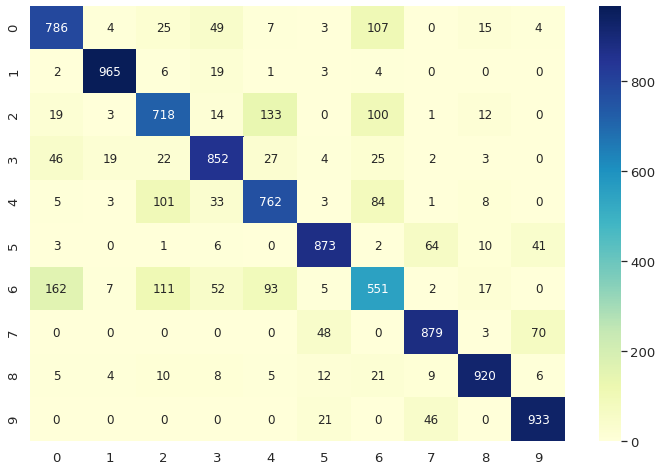

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Load test set.
df_test = pd.read_csv("/content/drive/Shared drives/mc886/fashion-mnist_test.csv") # Assuming you have this path

y_test = df_test['label'].to_numpy()
del df_test['label']
X_test = df_test.to_numpy().astype(np.float128) # float64 and below will overflow.
del df_test

regressor.standardScaler(X_test)

y_probabilities, y_predicted = regressor.predict(X_test)

accuracy = np.trace(matrix) / np.sum(matrix).astype('float')

print('Accuracy:', accuracy)

matrix = confusion_matrix(y_test, y_predicted)

df_cm = pd.DataFrame(matrix, range(10), range(10))
plt.figure(figsize=(12, 8))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g', cmap='YlGnBu') # font size

plt.show()

> What are the conclusions? (1-2 paragraphs)


Our model achieved an accuracy of 0.834. By looking at the confusion matrix, we can see that the main diagonal has numbers somewhat close to 1000 (which is the total number of samples for each class in this set), meaning that our model did a good job at classifying the pictures correctly. In particular, it did a good job at classyfing trousers (class 1), which makes sense since there are no other classes of clothes similar to trousers in the dataset.

There are some classes, however, that got our model confused. These are classes of clothes that look very similar to each other, like the class 0 (t-shirt/top) and class 6 (shirt), where our model predicted 162 shirts as being t-shirt/top. It makes sense that our model has trouble telling them apart, since they look very similar. Actually, class 6 in general got our model very confused, since it predicted correctly only 551 out of 1000.